In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

# **Analyses of Language Dependencies for Boardgames**

**Objective:** 

Assessment of boardgames available on Boardgame Geek API (BGG) to determine trends concerning language dependencies for game categories, game mechanics and rankings. Following section contains minor clean up of data.

In [2]:
lang_df = pd.read_csv('../data/language_vote_details.csv', low_memory=False)
df = pd.read_csv('../data/cleaned2.csv', low_memory=False)
ranks = pd.read_csv('../data/boardgames_ranks.csv', low_memory=False)

df['categories'] = df['categories']\
    .apply(lambda x: ast.literal_eval(x))
df['mechanics'] = df['mechanics']\
    .apply(lambda x: ast.literal_eval(x))

In [3]:
ranks.rename(columns={"id":"@id"}, inplace = True)
lang_df.rename(columns={"Language Dependency": "lang"}, inplace = True)

lang_df.head(2)

,@id,language_poll,Not Dependent,Somewhat,Moderately,Extensively,Fully,lang
0,1,"[[{'@level': '1', '@value': 'No necessary in-g...",37,5,7,0,0,Not Dependent
1,2,"[[{'@level': '6', '@value': 'No necessary in-g...",0,1,0,0,0,Somewhat


In [4]:
#correcting the lang column info for games with no votes

def no_language(row):
    if row["Not Dependent"] == 0 and \
        row["Somewhat"] == 0 and \
        row["Moderately"] == 0 and \
        row["Extensively"] == 0 and \
        row["Fully"] == 0:
        return "No Info"
    else: 
        return row["lang"]

lang_df["lang"] = lang_df.apply(no_language, axis = 1)

lang_df.head(2)

,@id,language_poll,Not Dependent,Somewhat,Moderately,Extensively,Fully,lang
0,1,"[[{'@level': '1', '@value': 'No necessary in-g...",37,5,7,0,0,Not Dependent
1,2,"[[{'@level': '6', '@value': 'No necessary in-g...",0,1,0,0,0,Somewhat


## **Part 1: Metrics for Game Titles, Rankings, and Language Dependencies**

### **1A. Data Prep**

In [5]:
# Data prep. Creating df containing columns for id, name, year, language, ranks 

merge_df = pd.merge(df[["@id", "name" , "year"]], ranks[["@id","rank"]], on = "@id", how = "inner")
games_df = pd.merge(merge_df, lang_df[["@id","lang"]], on = "@id", how = "inner")   

games = games_df.copy()
games.dropna(inplace = True)
display(games.head(2))

,@id,name,year,rank,lang
0,1,Die Macher,1986,409,Not Dependent
1,2,Dragonmaster,1981,4819,Somewhat


In [6]:
# bin by decade
bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ["1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]
games["decade"] = pd.cut(games["year"], bins = bins, labels = labels, right = False)


#display df output and some ranking info
no_rank = (games["rank"] != 0).sum()
display(games.head())
print(f"Number of games that have rankings: {no_rank}")
print(f"Lowest game ranking is: {games['rank'].max()}")

,@id,name,year,rank,lang,decade
0,1,Die Macher,1986,409,Not Dependent,1980s
1,2,Dragonmaster,1981,4819,Somewhat,1980s
2,3,Samurai,1998,266,Not Dependent,1990s
3,4,Tal der Könige,1992,6440,Not Dependent,1990s
4,5,Acquire,1963,335,Not Dependent,1960s


Number of games that have rankings: 25807
Lowest game ranking is: 25809


In [7]:
# add columns for grouped game ranks (e.g. games ranked 1 - 100, games ranked 101-500, etc)

def rank_groups(value, label):
    if value == "":
        return pd.NA
    value = int(value)
    
    if label == grouped_rankings[0] and value <= 100:
        return "True"
    elif label == grouped_rankings[1] and value >= 101 and value <= 500:
        return "True"
    elif label == grouped_rankings[2] and value >= 501 and value <= 1000:
        return "True"
    elif label == grouped_rankings[3] and value >= 1001 and value <= 2500:
        return "True"
    elif label == grouped_rankings[4] and value >= 2501 and value <= 4999:
        return "True"
    elif label == grouped_rankings[5] and value > 5000:
        return "True"
    else:
        return pd.NA

grouped_rankings = ["1 - 100", "101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"]


for label in grouped_rankings:
    games[label] = games["rank"].apply(lambda row: rank_groups(row, label))
    
    
games.head()

,@id,name,year,rank,lang,decade,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
0,1,Die Macher,1986,409,Not Dependent,1980s,<NA>,True,<NA>,<NA>,<NA>,<NA>
1,2,Dragonmaster,1981,4819,Somewhat,1980s,<NA>,<NA>,<NA>,<NA>,True,<NA>
2,3,Samurai,1998,266,Not Dependent,1990s,<NA>,True,<NA>,<NA>,<NA>,<NA>
3,4,Tal der Könige,1992,6440,Not Dependent,1990s,<NA>,<NA>,<NA>,<NA>,<NA>,True
4,5,Acquire,1963,335,Not Dependent,1960s,<NA>,True,<NA>,<NA>,<NA>,<NA>


In [8]:
games = games.convert_dtypes()

In [9]:
#creating df for games that have been ranked, non ranks were dropped as were games with no language info

drop_zero = games["rank"] == 0
games_rankings = games.drop(games[drop_zero].index)

drop_noinfo = games_rankings["lang"] == "No Info"
games_rankings = games_rankings.drop(games_rankings[drop_noinfo].index)

games_rankings.head(2)

,@id,name,year,rank,lang,decade,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
0,1,Die Macher,1986,409,Not Dependent,1980s,<NA>,True,<NA>,<NA>,<NA>,<NA>
1,2,Dragonmaster,1981,4819,Somewhat,1980s,<NA>,<NA>,<NA>,<NA>,True,<NA>


### **1B. Pivots and Plots**

In [10]:
#Pivoted to see if anything interesting regarding language dependencies and game popularity (grouped by rankings groups)

rankings_vs_lang = pd.pivot_table(games_rankings, 
                                index = 'lang', 
                                values = ["1 - 100", "101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"],
                                aggfunc='count')

rankings_vs_lang = rankings_vs_lang[grouped_rankings]

#updated the table's values to percentages.

def convert_to_percent(col):
    total_sum = col.sum()
    return col / total_sum

rankings_vs_lang_perc = rankings_vs_lang.apply(convert_to_percent) 

display(rankings_vs_lang_perc)

reorder_lang_dec= ["Not Dependent", "Somewhat", "Moderately", "Extensively", "Fully"]

rankings_vs_lang_perc = rankings_vs_lang_perc.reindex(reorder_lang_dec)

,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
lang,,,,,,
Extensively,0.36,0.1750,0.160,0.155749,0.146260,0.114249
Fully,0.03,0.0275,0.028,0.026070,0.022566,0.046784
Moderately,0.25,0.2750,0.214,0.198529,0.211450,0.251747
Not Dependent,0.29,0.3675,0.398,0.417781,0.421646,0.429183
Somewhat,0.07,0.1550,0.200,0.201872,0.198078,0.158037


,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
lang,,,,,,
Not Dependent,0.29,0.3675,0.398,0.417781,0.421646,0.429183
Somewhat,0.07,0.1550,0.200,0.201872,0.198078,0.158037
Moderately,0.25,0.2750,0.214,0.198529,0.211450,0.251747
Extensively,0.36,0.1750,0.160,0.155749,0.146260,0.114249
Fully,0.03,0.0275,0.028,0.026070,0.022566,0.046784


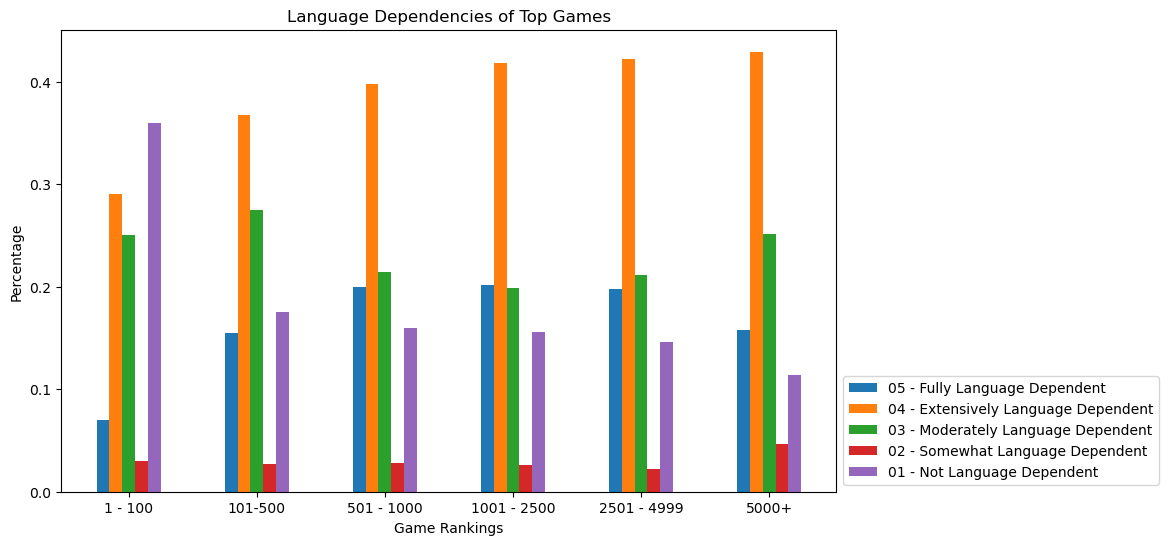

In [11]:
#setting up df info for plotting

perc_fully = rankings_vs_lang_perc.iloc[1,:].tolist()
perc_extensively = rankings_vs_lang_perc.iloc[0,:].tolist()
perc_moderately = rankings_vs_lang_perc.iloc[2,:].tolist()
perc_somewhat = rankings_vs_lang_perc.iloc[4,:].tolist()
perc_not_dependent = rankings_vs_lang_perc.iloc[3,:].tolist()

bar_width = 0.1

# note chatgpt assisted code for ticks and bar positioning.
x_positions = [i for i in range(len(grouped_rankings))]

# plotting the bars graph
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar([pos - 2*bar_width for pos in x_positions], perc_fully, bar_width, label="05 - Fully Language Dependent")
ax.bar([pos - bar_width for pos in x_positions], perc_extensively, bar_width, label='04 - Extensively Language Dependent')
ax.bar(x_positions, perc_moderately, bar_width, label='03 - Moderately Language Dependent')
ax.bar([pos + bar_width for pos in x_positions], perc_somewhat, bar_width, label='02 - Somewhat Language Dependent')
ax.bar([pos + 2*bar_width for pos in x_positions], perc_not_dependent, bar_width, label='01 - Not Language Dependent')


# adding the labels and title
ax.set_xlabel('Game Rankings')
ax.set_ylabel('Percentage')
ax.set_title("Language Dependencies of Top Games")
ax.legend(loc="lower left", bbox_to_anchor=(1, 0))

plt.xticks(x_positions, grouped_rankings)

display(rankings_vs_lang_perc)
# Show the plot
plt.show()


Analyses: 
    Language trends for the top 100 games are different

In [25]:
#plot lang and decades
lang_decades = games_rankings[["lang", "decade"]].copy()
lang_options = lang_decades["lang"].unique()

lang_vs_dec = pd.pivot_table(lang_decades, 
                                index = 'lang', 
                                columns = "decade",
                                aggfunc='size')

lang_vs_dec_perc = lang_vs_dec.apply(convert_to_percent).round(2)

reorder_lang_dec= ["Not Dependent", "Somewhat", "Moderately", "Extensively", "Fully"]

lang_vs_dec_perc = lang_vs_dec_perc.loc[reorder_lang_dec]

display(lang_vs_dec)
lang_vs_dec_perc

decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Extensively,8,30,84,175,453,1142,465
Fully,5,12,51,77,190,278,147
Moderately,33,340,449,471,746,1845,662
Not Dependent,75,181,301,632,1809,3645,1110
Somewhat,27,96,145,204,616,1609,429


decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Not Dependent,0.51,0.27,0.29,0.41,0.47,0.43,0.39
Somewhat,0.18,0.15,0.14,0.13,0.16,0.19,0.15
Moderately,0.22,0.52,0.44,0.30,0.20,0.22,0.24
Extensively,0.05,0.05,0.08,0.11,0.12,0.13,0.17
Fully,0.03,0.02,0.05,0.05,0.05,0.03,0.05


decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Not Dependent,0.51,0.27,0.29,0.41,0.47,0.43,0.39
Somewhat,0.18,0.15,0.14,0.13,0.16,0.19,0.15
Moderately,0.22,0.52,0.44,0.30,0.20,0.22,0.24
Extensively,0.05,0.05,0.08,0.11,0.12,0.13,0.17
Fully,0.03,0.02,0.05,0.05,0.05,0.03,0.05


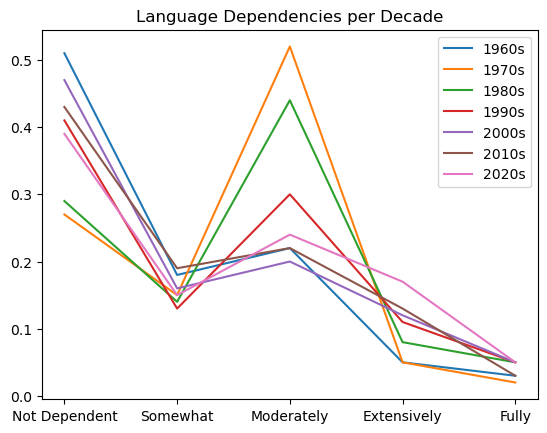

In [33]:
display(lang_vs_dec_perc)

decade_1960, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["1960s"], label = "1960s")
decade_1970, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["1970s"], label = "1970s")
decade_1980, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["1980s"], label = "1980s")
decade_1990, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["1990s"], label = "1990s")
decade_2000, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["2000s"], label = "2000s")
decade_2010, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["2010s"], label = "2010s")
decade_2020, = plt.plot(lang_vs_dec_perc.index, lang_vs_dec_perc["2020s"], label = "2020s")

plt.legend(handles=[decade_1960,decade_1970, decade_1980,decade_1990, decade_2000,decade_2010, decade_2020], loc = "best")
plt.title("Language Dependencies per Decade")
plt.show()

In [27]:
#plot number of games and lang dependency

lang_vsgames = pd.pivot_table(lang_decades, 
                                columns = 'lang', 
                                aggfunc='size')

lang_games_df = lang_vsgames.reset_index(name="no of games")

total_games = lang_games_df["no of games"].sum()

lang_games_df["percent"] = (lang_games_df["no of games"]/total_games).round(2)

lang_games_df.set_index("lang", drop=True, inplace = True)

lang_games_df = lang_games_df.loc[reorder_lang_dec]
display(lang_games_df)

,no of games,percent
lang,,
Not Dependent,8027,0.42
Somewhat,3161,0.17
Moderately,4575,0.24
Extensively,2371,0.13
Fully,778,0.04


#### Other: Charted game mechanics and types of games against languages. It would be interesting in a future analyses to review if any correlations and trends could be ascertained.

In [28]:
cat_merge_df = pd.merge(games_rankings[["@id", "name" , "year", "lang"]], df[["@id","categories", "mechanics"]], on = "@id", how = "inner")

In [29]:
def metric_by_year(data, metric):
    new_df = data[['lang', metric]].copy()
    new_df = new_df.explode(metric).reset_index(drop=True)
    return new_df
    
lang_cats = metric_by_year(cat_merge_df, 'categories')
lang_mechs = metric_by_year(cat_merge_df, 'mechanics')
display(lang_cats.head())
lang_mechs.head()


,lang,categories
0,Not Dependent,Economy / Industry
1,Not Dependent,Political
2,Not Dependent,Bluffing / Negotiation
3,Somewhat,Fantasy
4,Somewhat,Card Game


,lang,mechanics
0,Not Dependent,Simultaneous Action Selection
1,Not Dependent,Alliances
2,Not Dependent,Hand Management
3,Not Dependent,Auction
4,Not Dependent,Area Majority / Influence


In [30]:
lang_vscats = pd.pivot_table(lang_cats, 
                              index = "categories",
                                columns = 'lang', 
                                aggfunc='size')

display(lang_vscats)
lang_vscats_perc = lang_vscats.apply(convert_to_percent).round(2)
lang_vscats_perc

lang,Extensively,Fully,Moderately,Not Dependent,Somewhat
categories,,,,,
Abstract Strategy,8.0,2.0,35.0,1295.0,97.0
Action / Dexterity,26.0,17.0,34.0,664.0,70.0
Adventure,340.0,62.0,274.0,246.0,196.0
Age of Reason,32.0,2.0,86.0,25.0,31.0
Animals,44.0,10.0,124.0,911.0,191.0
...,...,...,...,...,...
Trivia,121.0,216.0,22.0,8.0,16.0
Video Game Theme,70.0,16.0,78.0,62.0,66.0
War,609.0,24.0,2284.0,355.0,607.0


lang,Extensively,Fully,Moderately,Not Dependent,Somewhat
categories,,,,,
Abstract Strategy,0.00,0.00,0.00,0.07,0.01
Action / Dexterity,0.00,0.01,0.00,0.04,0.01
Adventure,0.05,0.03,0.02,0.01,0.02
Age of Reason,0.00,0.00,0.01,0.00,0.00
Animals,0.01,0.00,0.01,0.05,0.02
...,...,...,...,...,...
Trivia,0.02,0.10,0.00,0.00,0.00
Video Game Theme,0.01,0.01,0.01,0.00,0.01
War,0.08,0.01,0.20,0.02,0.07


In [31]:
lang_vsmech = pd.pivot_table(lang_mechs, 
                              index = "mechanics",
                                columns = 'lang', 
                                aggfunc='size')

display(lang_vsmech)
lang_vsmech_perc = lang_vsmech.apply(convert_to_percent).round(2)
lang_vsmech_perc

lang,Extensively,Fully,Moderately,Not Dependent,Somewhat
mechanics,,,,,
Acting,40.0,45.0,21.0,43.0,20.0
Action Points,217.0,22.0,365.0,311.0,240.0
Action Queue,38.0,3.0,98.0,157.0,69.0
Action Retrieval,14.0,1.0,22.0,32.0,19.0
Action Timer,6.0,3.0,5.0,9.0,7.0
...,...,...,...,...,...
Voting,85.0,50.0,72.0,108.0,80.0
Worker Placement,55.0,5.0,194.0,400.0,182.0
Worker Placement with Dice Workers,4.0,NaN,22.0,38.0,19.0


lang,Extensively,Fully,Moderately,Not Dependent,Somewhat
mechanics,,,,,
Acting,0.00,0.03,0.00,0.00,0.00
Action Points,0.02,0.01,0.02,0.01,0.02
Action Queue,0.00,0.00,0.01,0.01,0.01
Action Retrieval,0.00,0.00,0.00,0.00,0.00
Action Timer,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...
Voting,0.01,0.03,0.00,0.00,0.01
Worker Placement,0.01,0.00,0.01,0.02,0.02
Worker Placement with Dice Workers,0.00,NaN,0.00,0.00,0.00
